# This Ipython notebook is a walkthrough for generating a VDE on top of an existing tICA model . 
#It requires the following libraries  
VDE is needed to actually fit the model 

1 ) https://github.com/msmbuilder/vde

MSMBuillder for the feature extractors + Scaling functions + tica models

2) https://github.com/msmbuilder/msmbuilder

In [1]:
import warnings
import msmexplorer as msme
warnings.filterwarnings('ignore')
import seaborn as sns
%pylab inline
import numpy as np
import os 
import pandas as pd
import mdtraj as md 
sns.set_style("whitegrid")
sns.set_context("talk",1.3)
from msmbuilder.utils import load,dump

Populating the interactive namespace from numpy and matplotlib


In [4]:
loc = "./sparse_cnt_mdl/"

In [89]:
# This MSMBUILDER object calculates both the CA- contacts and the closest heavy atom contacts

In [90]:
feat = load("%s/featurizer.pkl"%loc)

In [12]:
feat

FeatureSelector(features=OrderedDict([('cnt', ContactFeaturizer(contacts=[array([0, 3]), array([ 0, 31]), array([ 0, 32]), array([ 0, 33]), array([ 0, 34]), array([ 1, 31]), array([ 1, 34]), array([ 2, 31]), array([ 2, 32]), array([ 2, 33]), array([3, 6]), array([3, 7]), array([3, 8]), array([3, 9]), array([ 3, 19]..., 34])],
         ignore_nonprotein=True, scheme='ca', soft_min=False,
         soft_min_beta=10))]),
        which_feat=['cnt', 'ca_cnt'])

In [92]:
# This is the standard scaler from Scikit-learn

In [9]:
nrm = load("%s/nrm.pkl"%loc)

In [91]:
nrm

StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
# Again the pandas dataframe tells us exactly whats being computed

In [14]:
fip_df = pd.read_pickle("%s/fip/feature_descriptor.pkl"%loc)

In [93]:
# The fip_df can be generated from a FIP toopolgy via the following code
# fip_top = md.load("./fip_top.pdb")
# fip_df = pd.DataFrame(feat.describe_features(fip_top))

In [15]:
fip_df.tail()

,atominds,featuregroup,featurizer,otherinfo,resids,resnames,resseqs
179,"[[455], [507]]",ca,Contact,10,"[28, 31]","[GLN, ARG]","[29, 32]"
180,"[[455], [533]]",ca,Contact,10,"[28, 32]","[GLN, PRO]","[29, 33]"
181,"[[455], [545]]",ca,Contact,10,"[28, 33]","[GLN, SER]","[29, 34]"
182,"[[492], [559]]",ca,Contact,10,"[30, 34]","[GLU, GLY]","[31, 35]"
183,"[[507], [559]]",ca,Contact,10,"[31, 34]","[ARG, GLY]","[32, 35]"


# We have already fit a tica model for you. Take a look at the MSMBUILDER website if this step is confusing

In [18]:
tica_data = load("%s/fip/tica_data.pkl"%loc)
tica_mdl =load("%s/tica_mdl.pkl"%loc)

In [19]:
tica_mdl

SparseTICA(epsilon=1e-06, kinetic_mapping=False, lag_time=25, maxiter=10000,
      n_components=5, rho=0.001, shrinkage=None, tolerance=1e-06,
      verbose=False)

# We used sparse tica so we can limit how many contacts we have to compute at each timestep

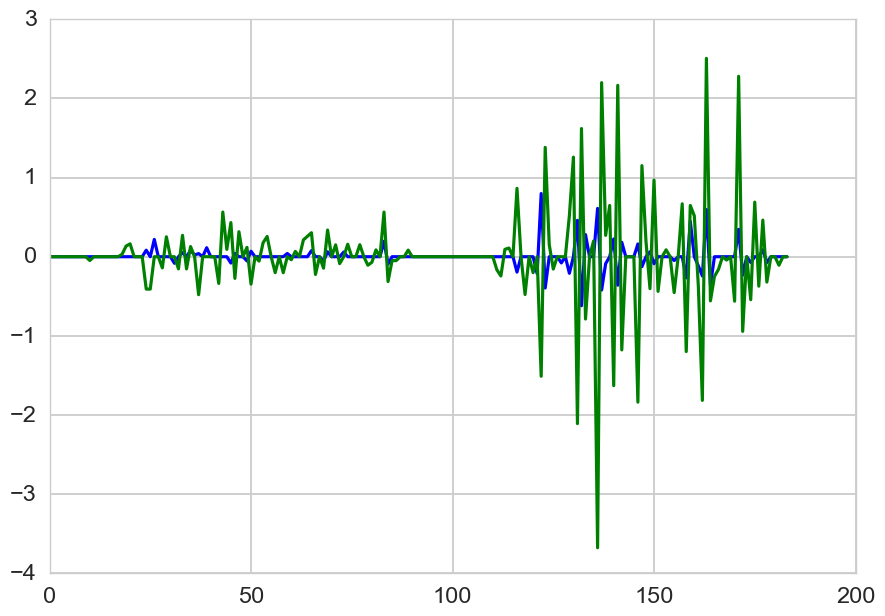

In [22]:
plot(tica_mdl.components_[0])
plot(tica_mdl.components_[1])

In [25]:
# We can encode the protein's tica data up to the 1st timescale ( or greater if need be). We pick
# the 1st because everything is faster than 100ns exchange below that 

[]

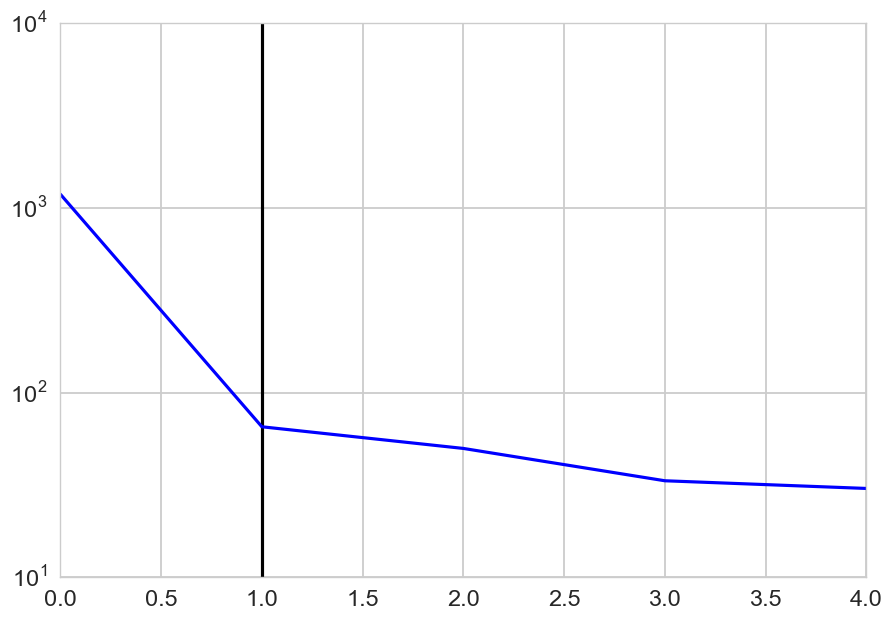

In [26]:
plot(tica_mdl.timescales_)
vlines(1,10,10000)
semilogy()

In [31]:
import torch
from vde import VDE

In [66]:
# Lets get our training data

In [28]:
train_tica_data = [tica_data[i][::1,:2] for i in tica_data.keys()]
concat_train_data = np.concatenate([tica_data[i][::1,:3] for i in tica_data.keys()])

# Again we provide a pre-trained model

In [37]:
model = torch.load("%s/vde_mdl_20nodes_tmp.pkl"%loc,map_location=lambda storage, loc: storage)

# OR you can fit a new model

In [33]:
# model = VDE(2,lag_time=25,hidden_layer_depth=2,hidden_size=20,n_epochs=100,batch_size=400,learning_rate=1e-2)
# model.dtype = torch.DoubleTensor
# model.use_cuda =False
# model.cpu()
# model.double()
# model.fit(train_tica_data)

In [34]:
# Lets take a look at the results

In [35]:
from torch.autograd import Variable
import torch

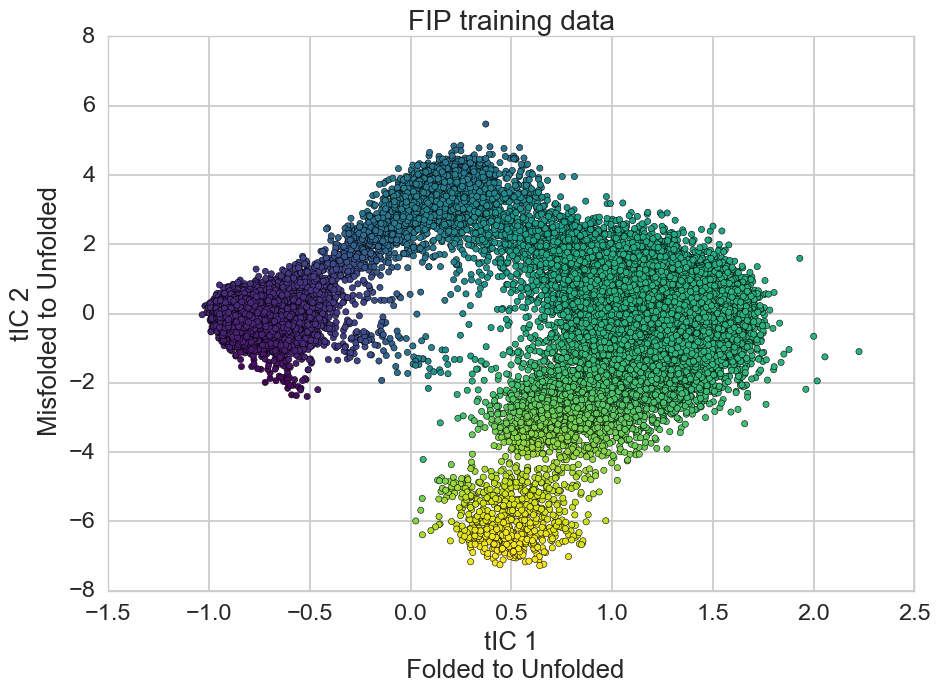

In [40]:
model.eval()
X=Variable(torch.from_numpy(concat_train_data[:,:model.input_size]).type(model.dtype))
output = model.encoder.output_layer(model.encoder.hidden_network(model.encoder.input_layer(X))).cpu().data.numpy()
p=scatter(concat_train_data[:,0],concat_train_data[:,1],c=output,cmap='viridis')
xlabel("tIC 1\n Folded to Unfolded")
ylabel("tIC 2\n Misfolded to Unfolded")
title("FIP training data")
cb.set_label("Latent Coordinate (z)")


# Again, similar to Alanine, our single coordinate can learn both of the slow modes as part of single CV. 

In [43]:
 # We can plot approximate free energies using MSMexplorer

(0, 9)

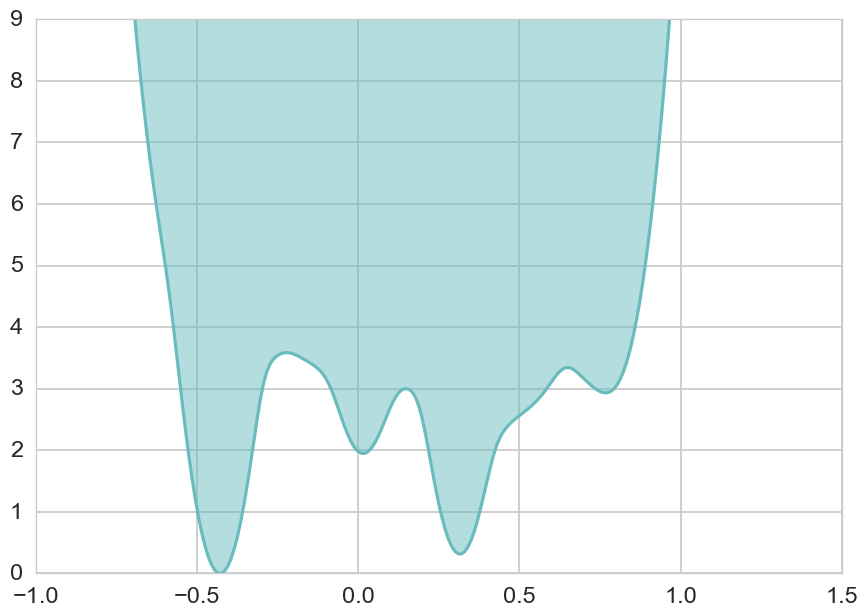

In [44]:
msme.plot_free_energy(output,gridsize=200)
ylim([0,9])

# For actually writing this network as Plumed files, lets load the helper functions

In [54]:
from vde_metadynamics.render_tics import *
from vde_metadynamics.render_df import *
from vde_metadynamics.render_network import *

In [65]:
all_output = []
all_out=[]
all_out.append("RESTART\n")
# Lets only calculate the contacts that are actually needed by the tica calculation/neural network 
inds = np.unique(np.nonzero(tica_mdl.components_[:2, :])[1])
all_out.extend(render_df(df=fip_df, inds=inds, nrm=nrm, tica_mdl=tica_mdl))
# We only need the first 2 tics
for i in range(2):
    all_out.extend(render_tic(tica_mdl=tica_mdl, tic_index=i, output_label_prefix="l0"))
    
#Finally we can also write out the model itself
all_out.extend(render_network(model))

2
Linear (20 -> 20) 3
3
Swish (
  (sigmoid): Sigmoid ()
) 4
4
Linear (20 -> 20) 5
5
Swish (
  (sigmoid): Sigmoid ()
) 6


# The full VDE network translated into Plumed is shown below

In [63]:
print("".join(all_out))

RESTART
DISTANCES GROUPA=43,45,47,50,52,56,60,61 GROUPB=90,92,95,96 MIN={BETA=10} LABEL=closest-heavy_3_6

DISTANCES GROUPA=62,63,66,68,71,74,75 GROUPB=121,123,125,128,131,132,133,134,135 MIN={BETA=10} LABEL=closest-heavy_4_8

DISTANCES GROUPA=62,63,66,68,71,74,75 GROUPB=355,357,359,362,363,364,367,368 MIN={BETA=10} LABEL=closest-heavy_4_21

DISTANCES GROUPA=62,63,66,68,71,74,75 GROUPB=530,531,534,536,539,542,543 MIN={BETA=10} LABEL=closest-heavy_4_32

DISTANCES GROUPA=90,92,95,96 GROUPB=335,337,339,342,343,345,347,349,351,353,354 MIN={BETA=10} LABEL=closest-heavy_6_20

DISTANCES GROUPA=90,92,95,96 GROUPB=355,357,359,362,363,364,367,368 MIN={BETA=10} LABEL=closest-heavy_6_21

DISTANCES GROUPA=90,92,95,96 GROUPB=369,371,373,376,378,379,381,382,384,385 MIN={BETA=10} LABEL=closest-heavy_6_22

DISTANCES GROUPA=97,99,101,104,105,107,109,110,111,113,115,117,119,120 GROUPB=314,316,318,321,322,324,326,327,329,331,333,334 MIN={BETA=10} LABEL=closest-heavy_7_19

DISTANCES GROUPA=97,99,101,104,10

# "l7_0" in the Plumed code above is the latent coordinate that we can accelerate via Metadynamics/ABF/etc

# To sample the GTT mutant, we only need to change the dataframe (fip_df) object above

In [95]:
# The gtt dataframe can be generated from a GTT toopolgy via the following code
# gtt_top = md.load("./gtt_top.pdb") 
# gtt_df = pd.DataFrame(feat.describe_features(gtt_top))

In [96]:
gtt_df = pd.read_pickle("%s/gtt/feature_descriptor.pkl"%loc)

In [97]:
# Note how the atom inds for certain row (ex 178) are now differnt, 
# This is because the ca index for that residue in the GTT-WW domain is differnt from the FIP-WW and the MSMbuilder 
# featurizer object can automatically learn that when it creates the dataframe. 



In [98]:
fip_df.tail(7)

,atominds,featuregroup,featurizer,otherinfo,resids,resnames,resseqs
177,"[[370], [420]]",ca,Contact,10,"[22, 25]","[HIS, ASN]","[23, 26]"
178,"[[370], [434]]",ca,Contact,10,"[22, 26]","[HIS, ALA]","[23, 27]"
179,"[[455], [507]]",ca,Contact,10,"[28, 31]","[GLN, ARG]","[29, 32]"
180,"[[455], [533]]",ca,Contact,10,"[28, 32]","[GLN, PRO]","[29, 33]"
181,"[[455], [545]]",ca,Contact,10,"[28, 33]","[GLN, SER]","[29, 34]"
182,"[[492], [559]]",ca,Contact,10,"[30, 34]","[GLU, GLY]","[31, 35]"
183,"[[507], [559]]",ca,Contact,10,"[31, 34]","[ARG, GLY]","[32, 35]"


In [99]:
gtt_df.tail(7)

,atominds,featuregroup,featurizer,otherinfo,resids,resnames,resseqs
177,"[[370], [420]]",ca,Contact,10,"[22, 25]","[HIS, GLY]","[23, 26]"
178,"[[370], [427]]",ca,Contact,10,"[22, 26]","[HIS, THR]","[23, 27]"
179,"[[455], [507]]",ca,Contact,10,"[28, 31]","[GLN, ARG]","[29, 32]"
180,"[[455], [533]]",ca,Contact,10,"[28, 32]","[GLN, PRO]","[29, 33]"
181,"[[455], [545]]",ca,Contact,10,"[28, 33]","[GLN, SER]","[29, 34]"
182,"[[492], [559]]",ca,Contact,10,"[30, 34]","[GLU, GLY]","[31, 35]"
183,"[[507], [559]]",ca,Contact,10,"[31, 34]","[ARG, GLY]","[32, 35]"


## WARNING: The featurizer assumes that the sequence is conserverd and WILL NOT work if you have insertions or deletions. Make sure that you compare the dataframe objects across mutants to be sure that they represent "equivalent" features 

In [100]:
# To get the neural network for the GTT mutant, we simply swap the gtt_df in the render_df  function

In [103]:
all_output = []
all_out=[]
all_out.append("RESTART\n")
inds = np.unique(np.nonzero(tica_mdl.components_[:2, :])[1])
# THE ONLY CHANGE TO MAKE IS IN THE LINE BELOW. 
all_out.extend(render_df(df=gtt_df, inds=inds, nrm=nrm, tica_mdl=tica_mdl))

for i in range(2):
    all_out.extend(render_tic(tica_mdl=tica_mdl, tic_index=i, output_label_prefix="l0"))
    
all_out.extend(render_network(model))

2
Linear (20 -> 20) 3
3
Swish (
  (sigmoid): Sigmoid ()
) 4
4
Linear (20 -> 20) 5
5
Swish (
  (sigmoid): Sigmoid ()
) 6


In [102]:
print("".join(all_out))

RESTART
DISTANCES GROUPA=43,45,47,50,52,56,60,61 GROUPB=90,92,95,96 MIN={BETA=10} LABEL=closest-heavy_3_6

DISTANCES GROUPA=62,63,66,68,71,74,75 GROUPB=121,123,125,128,131,132,133,134,135 MIN={BETA=10} LABEL=closest-heavy_4_8

DISTANCES GROUPA=62,63,66,68,71,74,75 GROUPB=355,357,359,362,363,364,367,368 MIN={BETA=10} LABEL=closest-heavy_4_21

DISTANCES GROUPA=62,63,66,68,71,74,75 GROUPB=530,531,534,536,539,542,543 MIN={BETA=10} LABEL=closest-heavy_4_32

DISTANCES GROUPA=90,92,95,96 GROUPB=335,337,339,342,343,345,347,349,351,353,354 MIN={BETA=10} LABEL=closest-heavy_6_20

DISTANCES GROUPA=90,92,95,96 GROUPB=355,357,359,362,363,364,367,368 MIN={BETA=10} LABEL=closest-heavy_6_21

DISTANCES GROUPA=90,92,95,96 GROUPB=369,371,373,376,378,379,381,382,384,385 MIN={BETA=10} LABEL=closest-heavy_6_22

DISTANCES GROUPA=97,99,101,104,105,107,109,110,111,113,115,117,119,120 GROUPB=314,316,318,321,322,324,326,327,329,331,333,334 MIN={BETA=10} LABEL=closest-heavy_7_19

DISTANCES GROUPA=97,99,101,104,10

# We can now sample both the FIP WT and the GTT mutant using the same VDE coordinate (l7_0) via Plumed 